In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

In [17]:
#import extracted terms as dataframe
df_extracted_terms=pd.read_csv('processed_data/extracted_HPO_terms.csv')
df_clinical_annotations=pd.read_csv('processed_data/clinical_annotations.csv')

In [18]:
df_clinical_annotations.head()

,OrphaCode,Name,HPO_term,HPO_frequency,HPO_ID
0,58,Alexander disease,Macrocephaly,Very frequent (99-80%),256
1,58,Alexander disease,Intellectual disability,Very frequent (99-80%),1249
2,58,Alexander disease,Seizure,Very frequent (99-80%),1250
3,58,Alexander disease,Spasticity,Very frequent (99-80%),1257
4,58,Alexander disease,Agenesis of corpus callosum,Very frequent (99-80%),1274


In [90]:
def HPO_word_count(df,col_name1, col_name2,file_name):
    
    word_count=lambda s:len(s.split())
    df[col_name1]=df[col_name2].apply(word_count)
    display(df.head())
    df.to_csv(f'SQL_scripts/{file_name}_wc.csv')
    return df

In [91]:
df_clinical_annotations=HPO_word_count(df_clinical_annotations,'word_count','HPO_term',file_name='clinical_annotations_wc')


,OrphaCode,Name,HPO_term,HPO_frequency,HPO_ID,word_count,Classification
0,58,Alexander disease,Macrocephaly,Very frequent (99-80%),256,1,Rare neurologic disease
1,58,Alexander disease,Intellectual disability,Very frequent (99-80%),1249,2,Rare neurologic disease
2,58,Alexander disease,Seizure,Very frequent (99-80%),1250,1,Rare neurologic disease
3,58,Alexander disease,Spasticity,Very frequent (99-80%),1257,1,Rare neurologic disease
4,58,Alexander disease,Agenesis of corpus callosum,Very frequent (99-80%),1274,4,Rare neurologic disease


In [93]:
df_extracted_mapped_terms_wc=HPO_word_count(df_extracted_terms,'word_count','HPO_phenotype','extracted_mapped_terms_wc')

,OrphaCode,HPO_phenotype,HPO_ID,word_count
0,166024,macrocephaly,256,1
1,166024,joint swelling,1386,2
2,166024,genu valgum,2857,2
3,166024,clinodactyly,30084,1
4,166024,spindle-shaped finger,31092,2


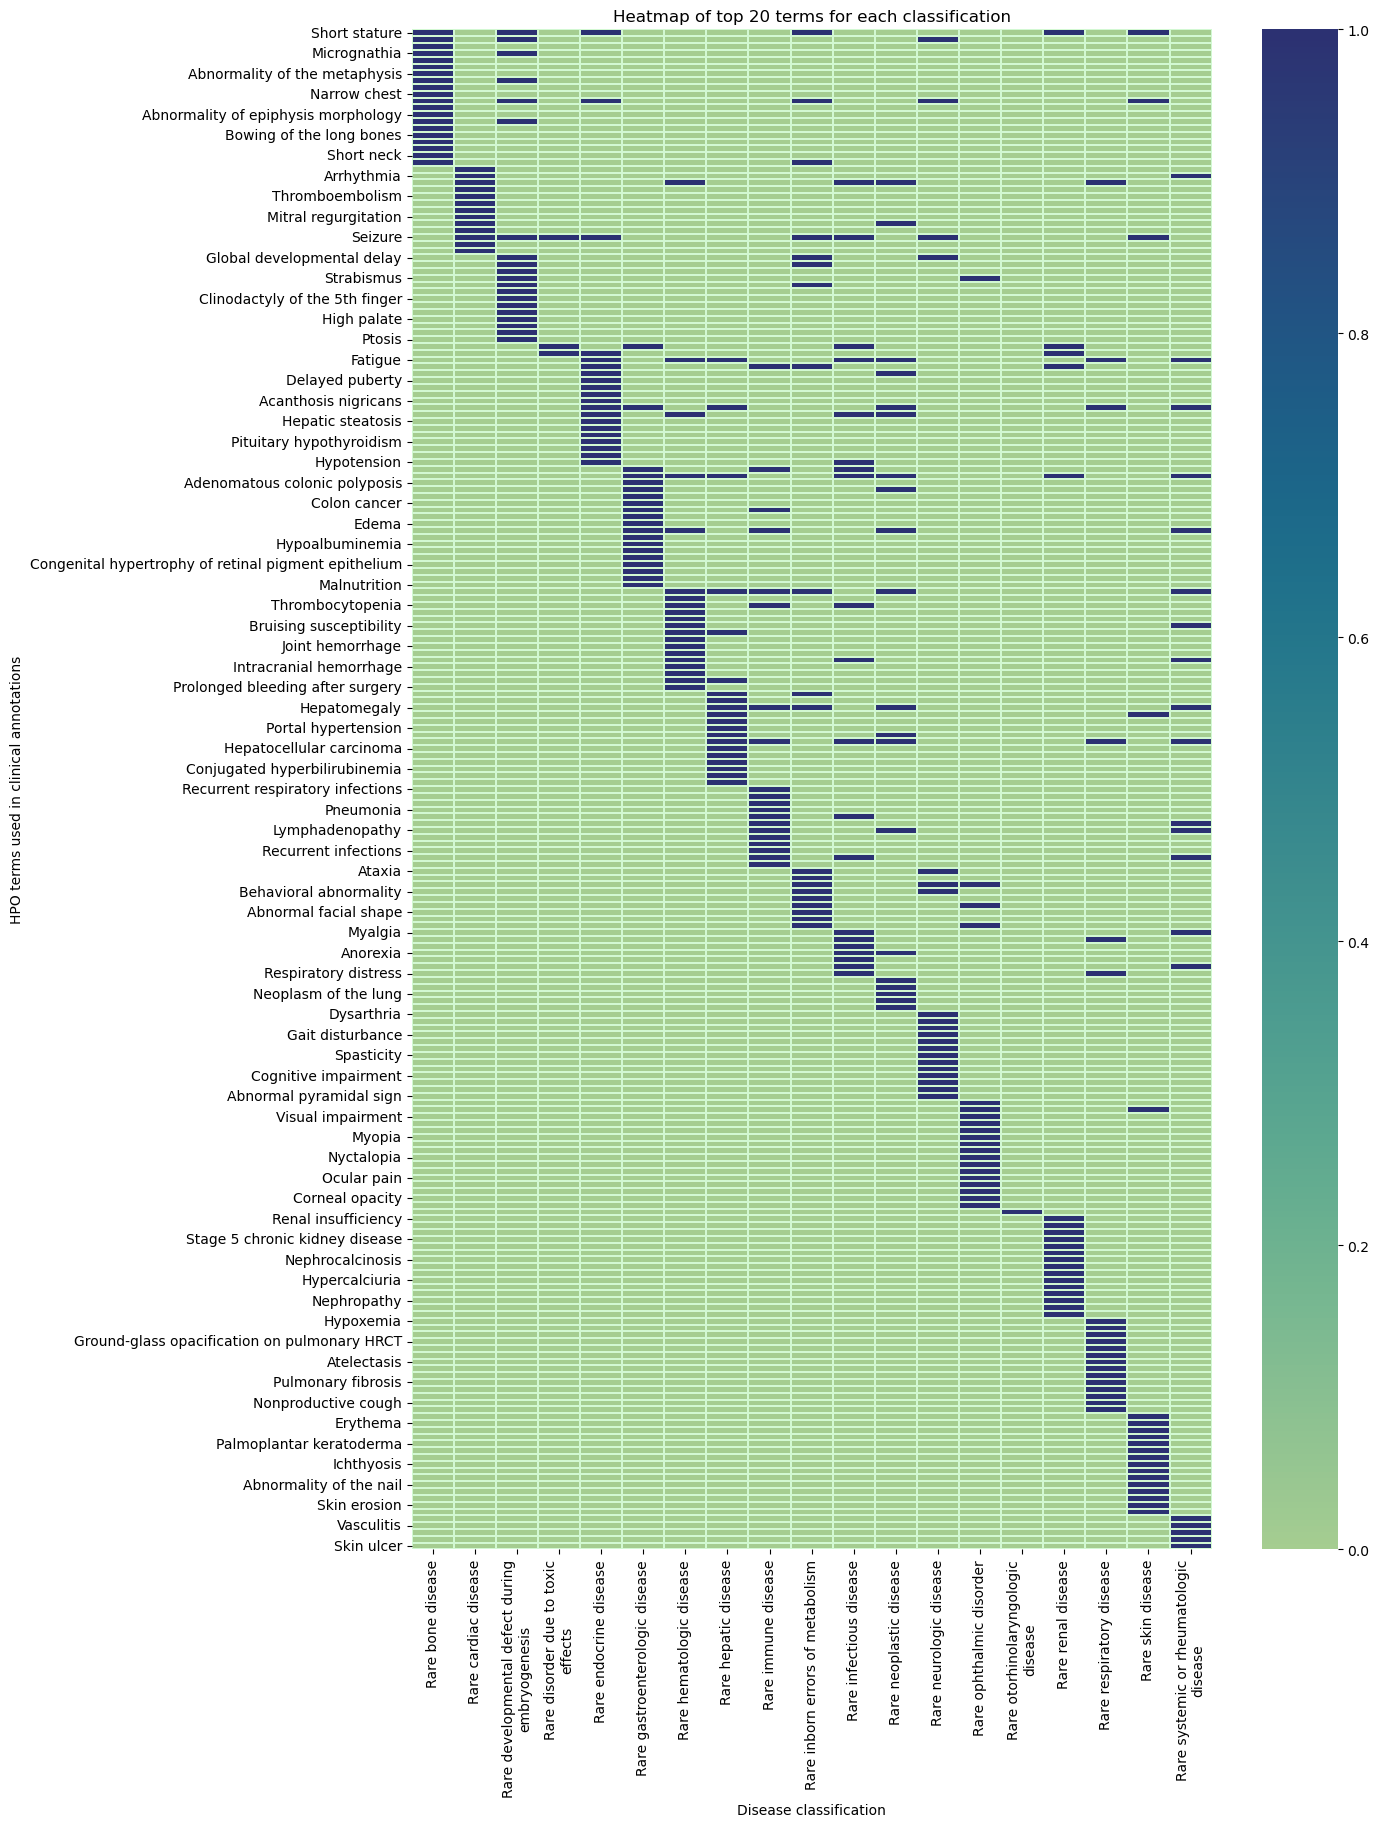

In [217]:
def heat_map_terms_by_class(clinical_annotations_fname,linearized_fname,top_n):
    import textwrap
    
    
    
    #import linearized disease file containing primary classifications and set index to OrphaCode
    df_linearized=pd.read_csv(f'processed_data/{linearized_fname}.csv')
    df_linearized.set_index('OrphaCode', inplace=True)   
    
    #map classification to disease codes (orpha codes) in the clinical annotations file 
    df_class_clin_anot=pd.read_csv(f'processed_data/{clinical_annotations_fname}.csv')

    df_class_clin_anot['Classification']=df_class_clin_anot['OrphaCode'].map(df_linearized['ClassNames'])

    # return class for which term most used, this will be used to group terms by their preferential class
    max_class = df_class_clin_anot.groupby("HPO_ID")["Classification"].agg(lambda x: x.value_counts().index[0] if len(x.value_counts()) > 0 and x.value_counts().max() > 1 else x.iloc[0])
    
    # add the preferred classification (max_classification column) to the original table
    df_class_clin_anot['max_classification'] = df_class_clin_anot["HPO_ID"].map(max_class)
    #sort terms based on their preferred class
    df_class_clin_anot.sort_values(by='max_classification', inplace=True)
    
    #count the number of times the term is used in each class
    counts = df_class_clin_anot.groupby(['Classification', 'HPO_term']).size().reset_index(name='count')

    # use nlargest to get the top 10 HPO terms per classification, and drop all terms with count less than 5
    top_10 = counts.groupby('Classification').apply(lambda x: x.nlargest(top_n, 'count')).reset_index(drop=True)
    top_10.drop(top_10[top_10['count']<=5].index, inplace=True)
    
    # pivot table to just have classification, terms and count, keep sort from earlier
    pivot_table_10=pd.pivot_table(data=top_10, index= ['HPO_term'], columns=['Classification'], values='HPO_term', aggfunc='count', sort=False)
    pivot_table_10.fillna(0,inplace=True)
    
    # plot heatmap
    
    fig, ax=plt.subplots(figsize=(25,40))
    fig.subplots_adjust(left=0.5, bottom=0.5)
    color_palette=sns.color_palette()
    max_width=32 # limits length of char per line
    xticklabels = [textwrap.fill(label, width=max_width) for label in pivot_table_10.columns]
    sns.heatmap(pivot_table_10, cmap='crest', xticklabels=xticklabels, linewidths=0.01,linecolor='#d2f8d2')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    #ax.set_yticks(range(len(pivot_table_10.index)))
    #ax.set_yticklabels(pivot_table_10.index)
    plt.title(f'Heatmap of top {top_n} terms for each classification')
    plt.ylabel('HPO terms used in clinical annotations')
    plt.xlabel('Disease classification')
    plt.savefig(f'viz/heatmap_terms_top_{top_n}.png')

heat_map_terms_by_class('clinical_annotations', 'orpha_linearized',20)

In [169]:
pd.set_option('display.max_rows',None)
counts=df_class_clin_anot.groupby(['Classification', 'HPO_term']).size().reset_index(name='count')
top_n=counts.groupby('Classification').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)


HPO_ID
2                                  Rare endocrine disease
3          Rare developmental defect during embryogenesis
8          Rare developmental defect during embryogenesis
9                                 Rare neurologic disease
10         Rare developmental defect during embryogenesis
                                ...                      
3000052                                 Rare bone disease
3000061                          Rare ophthalmic disorder
3000062    Rare developmental defect during embryogenesis
3000066    Rare developmental defect during embryogenesis
3000077                            Rare endocrine disease
Name: Classification, Length: 8308, dtype: object

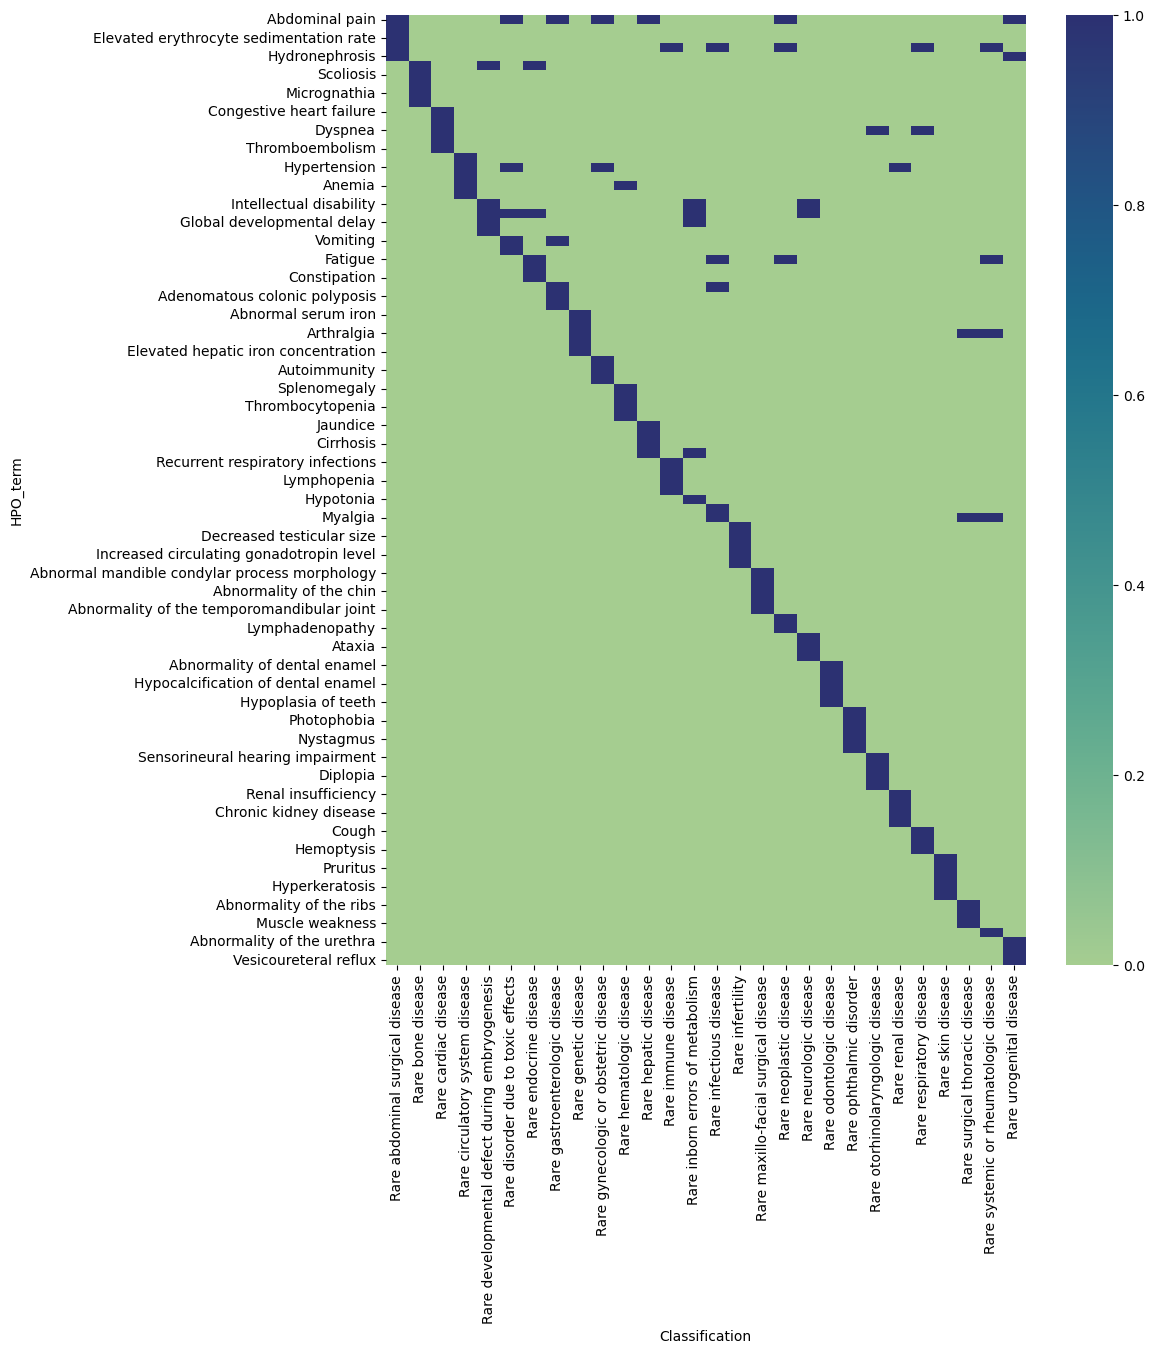

In [151]:
fig, ax=plt.subplots(figsize=(20,25))
fig.subplots_adjust(left=0.5, bottom=0.5)
color_palette=sns.color_palette()
sns.heatmap(pivot_table_10, cmap='crest')
plt.savefig('viz/heatmap_terms_top_5.png')